# Inventory Optimization Model

## Risk-Aware Material Allocation Optimization
**Group 7**

This notebook implements the inventory optimization model that:
1. Takes demand forecasts as input
2. Optimizes inventory transfers between stores
3. Determines manufacturing/replenishment quantities
4. Minimizes total supply chain costs

---


## 1. Setup and Imports


In [2]:
!pip3 install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 34.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import json
from pulp import *
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# print("PuLP version:", pulp.VERSION)
print("Setup complete!")


Setup complete!


## 2. Load Input Data

Loading:
1. **Demand forecasts** - 7-day horizon predictions per store-product
2. **Historical demand parameters** - For safety stock calculation
3. **Store supply parameters** - Lead times, shipping costs from spatial clustering
4. **Transport cost matrix** - Store-to-store transfer costs


In [2]:
# =============================================================================
# Load demand forecasts (7-day horizon)
# =============================================================================
forecast_long = pd.read_csv('../data/demand-forecast-output/product_forecasts.csv')
forecast_wide = pd.read_csv('../data/demand-forecast-output/product_forecasts_wide.csv')
forecast_metrics = pd.read_csv('../data/demand-forecast-output/product_forecast_metrics.csv')

print(f"Forecast data loaded:")
print(f"  Long format: {forecast_long.shape[0]:,} rows")
print(f"  Wide format: {forecast_wide.shape[0]:,} store-product combinations")
print(f"  Unique stores: {forecast_wide['store_id'].nunique()}")
print(f"  Unique products: {forecast_wide['product_id'].nunique()}")

# Aggregate 7-day forecasts to get total demand for planning horizon
demand_7day = forecast_wide.copy()
demand_7day['total_demand_7d'] = demand_7day[[f'day+{i}' for i in range(1, 8)]].sum(axis=1)
demand_7day['avg_daily_demand'] = demand_7day['total_demand_7d'] / 7

print(f"\n7-day total demand range: {demand_7day['total_demand_7d'].min():.1f} - {demand_7day['total_demand_7d'].max():.1f}")
display(demand_7day.head())


Forecast data loaded:
  Long format: 7,000 rows
  Wide format: 1,000 store-product combinations
  Unique stores: 20
  Unique products: 139

7-day total demand range: 2.5 - 70.1


,store_id,product_id,day+1,day+2,day+3,day+4,day+5,day+6,day+7,total_demand_7d,avg_daily_demand
0,1,4,2.253,2.254,2.622,3.628,3.856,2.302,2.280,19.195,2.742143
1,1,6,1.560,1.429,1.427,1.450,1.360,1.413,1.373,10.012,1.430286
2,1,19,2.409,2.414,2.105,1.978,2.002,1.975,2.042,14.925,2.132143
3,1,23,1.407,1.463,1.334,1.326,1.574,1.205,1.095,9.404,1.343429
4,1,26,0.845,0.864,1.036,1.091,1.313,0.857,0.928,6.934,0.990571


In [3]:
# =============================================================================
# Load historical demand parameters (for safety stock calculation)
# =============================================================================
historical_params = pd.read_csv('../data/processed_store_product_params.csv')

print(f"Historical parameters: {historical_params.shape[0]:,} store-product combinations")
print(f"Columns: {list(historical_params.columns)}")

# Join demand forecast with historical std for safety stock
demand_df = demand_7day.merge(
    historical_params[['store_id', 'product_id', 'demand_std', 'demand_cv', 'city_id']],
    on=['store_id', 'product_id'],
    how='left'
)

# Fill missing std with average (for store-products not in historical data)
demand_df['demand_std'] = demand_df['demand_std'].fillna(demand_df['avg_daily_demand'] * 0.5)
demand_df['demand_cv'] = demand_df['demand_cv'].fillna(0.5)
demand_df['city_id'] = demand_df['city_id'].fillna(0).astype(int)

print(f"\nDemand data with uncertainty: {demand_df.shape[0]} rows")
display(demand_df.head())


Historical parameters: 50,000 store-product combinations
Columns: ['store_id', 'product_id', 'city_id', 'avg_daily_demand', 'demand_std', 'total_demand', 'num_days', 'avg_stockout_hours', 'avg_discount', 'holiday_proportion', 'promotion_proportion', 'demand_cv', 'current_inventory', 'inventory_imbalance']

Demand data with uncertainty: 1000 rows


,store_id,product_id,day+1,day+2,day+3,day+4,day+5,day+6,day+7,total_demand_7d,avg_daily_demand,demand_std,demand_cv,city_id
0,1,4,2.253,2.254,2.622,3.628,3.856,2.302,2.280,19.195,2.742143,3.784209,0.898862,0
1,1,6,1.560,1.429,1.427,1.450,1.360,1.413,1.373,10.012,1.430286,0.663231,0.609090,0
2,1,19,2.409,2.414,2.105,1.978,2.002,1.975,2.042,14.925,2.132143,0.900476,0.433848,0
3,1,23,1.407,1.463,1.334,1.326,1.574,1.205,1.095,9.404,1.343429,0.589621,0.601995,0
4,1,26,0.845,0.864,1.036,1.091,1.313,0.857,0.928,6.934,0.990571,0.392666,0.387712,0


In [4]:
# =============================================================================
# Load store supply parameters (from spatial clustering)
# =============================================================================
store_params = pd.read_csv('../data/store_supply_params.csv')

print(f"Store supply parameters: {store_params.shape[0]} stores")
print(f"Columns: {list(store_params.columns)}")

# Key parameters for optimization
key_params = ['store_id', 'city_id', 'shipping_costs_mean', 'lead_time_days_mean', 
              'delay_probability_mean', 'supplier_reliability_score_mean',
              'disruption_likelihood_score_mean']
display(store_params[key_params].head(10))


Store supply parameters: 898 stores
Columns: ['store_id', 'city_id', 'geo_cluster', 'shipping_costs_mean', 'shipping_costs_std', 'lead_time_days_mean', 'lead_time_days_std', 'delay_probability_mean', 'delay_probability_std', 'delivery_time_deviation_mean', 'delivery_time_deviation_std', 'route_risk_level_mean', 'disruption_likelihood_score_mean', 'supplier_reliability_score_mean', 'traffic_congestion_level_mean', 'weather_condition_severity_mean', 'warehouse_inventory_level_mean', 'centroid_lat', 'centroid_lon', 'n_records']


,store_id,city_id,shipping_costs_mean,lead_time_days_mean,delay_probability_mean,supplier_reliability_score_mean,disruption_likelihood_score_mean
0,0,0,461.062874,5.202010,0.709998,0.511795,0.808774
1,1,0,461.062874,5.202010,0.709998,0.511795,0.808774
2,2,0,461.062874,5.202010,0.709998,0.511795,0.808774
3,3,10,473.812399,5.243829,0.686143,0.498968,0.800725
4,4,10,473.812399,5.243829,0.686143,0.498968,0.800725
5,5,5,437.227507,5.217698,0.705930,0.504638,0.795406
6,6,5,437.227507,5.217698,0.705930,0.504638,0.795406
7,7,5,437.227507,5.217698,0.705930,0.504638,0.795406
8,8,0,461.062874,5.202010,0.709998,0.511795,0.808774
9,9,15,459.511482,5.116855,0.704972,0.507852,0.805780


In [5]:
# =============================================================================
# Load transport cost matrix (store-to-store)
# =============================================================================
transport_df = pd.read_csv('../data/transport_cost_matrix_clustered_coords.csv', index_col=0)
transport_matrix = transport_df.values

print(f"Transport cost matrix shape: {transport_matrix.shape}")
print(f"Cost range: ${transport_matrix[transport_matrix > 0].min():.2f} - ${transport_matrix.max():.2f}")

# Filter to only stores in forecast data
forecast_stores = sorted(demand_df['store_id'].unique())
print(f"\nStores in forecast: {len(forecast_stores)}")
print(f"Store IDs: {forecast_stores}")


Transport cost matrix shape: (898, 898)
Cost range: $20.00 - $461.47

Stores in forecast: 20
Store IDs: [np.int64(1), np.int64(18), np.int64(29), np.int64(46), np.int64(60), np.int64(74), np.int64(118), np.int64(131), np.int64(134), np.int64(145), np.int64(147), np.int64(151), np.int64(154), np.int64(181), np.int64(182), np.int64(183), np.int64(187), np.int64(188), np.int64(194), np.int64(196)]


## 3. Create Current Inventory

Simulate current inventory levels based on historical patterns.
In production, this would come from actual inventory management system.


In [6]:
# =============================================================================
# Simulate current inventory based on historical patterns
# =============================================================================
np.random.seed(42)

# Get current inventory from historical data if available
if 'current_inventory' in historical_params.columns:
    inventory_lookup = historical_params.set_index(['store_id', 'product_id'])['current_inventory'].to_dict()
    demand_df['current_inventory'] = demand_df.apply(
        lambda row: inventory_lookup.get((row['store_id'], row['product_id']), 
                                          row['total_demand_7d'] * np.random.uniform(0.3, 0.8)),
        axis=1
    )
else:
    # Simulate: inventory between 30%-80% of 7-day demand (some shortage, some excess)
    demand_df['current_inventory'] = demand_df['total_demand_7d'] * np.random.uniform(0.3, 0.8, len(demand_df))

# Calculate inventory gap
demand_df['inventory_gap'] = demand_df['total_demand_7d'] - demand_df['current_inventory']
demand_df['shortage'] = demand_df['inventory_gap'].clip(lower=0)
demand_df['excess'] = (-demand_df['inventory_gap']).clip(lower=0)

print(f"Inventory analysis:")
print(f"  Total stores with shortage: {(demand_df['shortage'] > 0).sum()}")
print(f"  Total stores with excess: {(demand_df['excess'] > 0).sum()}")
print(f"  Total shortage units: {demand_df['shortage'].sum():,.1f}")
print(f"  Total excess units: {demand_df['excess'].sum():,.1f}")

display(demand_df[['store_id', 'product_id', 'total_demand_7d', 'current_inventory', 'inventory_gap', 'shortage', 'excess']].head(10))


Inventory analysis:
  Total stores with shortage: 568
  Total stores with excess: 432
  Total shortage units: 2,606.8
  Total excess units: 1,727.4


,store_id,product_id,total_demand_7d,current_inventory,inventory_gap,shortage,excess
0,1,4,19.195,6.308834,12.886166,12.886166,0.000000
1,1,6,10.012,9.501639,0.510361,0.510361,0.000000
2,1,19,14.925,16.085424,-1.160424,0.000000,1.160424
3,1,23,9.404,9.895893,-0.491893,0.000000,0.491893
4,1,26,6.934,5.987170,0.946830,0.946830,0.000000
5,1,38,5.503,5.087399,0.415601,0.415601,0.000000
6,1,58,6.731,7.684121,-0.953121,0.000000,0.953121
7,1,70,46.024,41.526267,4.497733,4.497733,0.000000
8,1,76,9.800,10.265501,-0.465501,0.000000,0.465501
9,1,90,13.846,9.804280,4.041720,4.041720,0.000000


## 4. Calculate Safety Stock

Safety stock formula:
$$\text{Safety Stock} = z \times \sigma_d \times \sqrt{L}$$

Where:
- $z$ = service level factor (1.65 for 95%)  
- $\sigma_d$ = demand standard deviation
- $L$ = lead time in days


In [7]:
# =============================================================================
# Safety Stock Calculation
# =============================================================================

# Service level configuration
Z_95 = 1.65  # 95% service level

# Add lead time and delay info from store params
demand_df = demand_df.merge(
    store_params[['store_id', 'lead_time_days_mean', 'delay_probability_mean', 
                   'disruption_likelihood_score_mean', 'supplier_reliability_score_mean']],
    on='store_id',
    how='left'
)

# Fill missing values with averages
demand_df['lead_time_days_mean'] = demand_df['lead_time_days_mean'].fillna(5)
demand_df['delay_probability_mean'] = demand_df['delay_probability_mean'].fillna(0.7)

# Calculate safety stock with risk adjustment
# Higher delay probability → higher safety stock multiplier
demand_df['risk_factor'] = 1 + demand_df['delay_probability_mean']
demand_df['safety_stock'] = (
    Z_95 * 
    demand_df['demand_std'] * 
    np.sqrt(demand_df['lead_time_days_mean']) * 
    demand_df['risk_factor']
)

# Calculate target inventory (demand + safety stock)
demand_df['target_inventory'] = demand_df['total_demand_7d'] + demand_df['safety_stock']
demand_df['required_replenishment'] = (demand_df['target_inventory'] - demand_df['current_inventory']).clip(lower=0)

print(f"Safety stock statistics:")
print(f"  Average safety stock: {demand_df['safety_stock'].mean():.1f} units")
print(f"  Min safety stock: {demand_df['safety_stock'].min():.1f} units")
print(f"  Max safety stock: {demand_df['safety_stock'].max():.1f} units")
print(f"\nTotal required replenishment: {demand_df['required_replenishment'].sum():,.1f} units")

display(demand_df[['store_id', 'product_id', 'demand_std', 'lead_time_days_mean', 'safety_stock', 
                   'target_inventory', 'current_inventory', 'required_replenishment']].head(10))


Safety stock statistics:
  Average safety stock: 5.6 units
  Min safety stock: 1.4 units
  Max safety stock: 31.9 units

Total required replenishment: 6,785.1 units


,store_id,product_id,demand_std,lead_time_days_mean,safety_stock,target_inventory,current_inventory,required_replenishment
0,1,4,3.784209,5.20201,24.352314,43.547314,6.308834,37.238481
1,1,6,0.663231,5.20201,4.268054,14.280054,9.501639,4.778414
2,1,19,0.900476,5.20201,5.794782,20.719782,16.085424,4.634359
3,1,23,0.589621,5.20201,3.794354,13.198354,9.895893,3.302461
4,1,26,0.392666,5.20201,2.526902,9.460902,5.987170,3.473732
5,1,38,1.431595,5.20201,9.212664,14.715664,5.087399,9.628265
6,1,58,0.410390,5.20201,2.640960,9.371960,7.684121,1.687838
7,1,70,2.173968,5.20201,13.990020,60.014020,41.526267,18.487752
8,1,76,0.923960,5.20201,5.945913,15.745913,10.265501,5.480411
9,1,90,1.395547,5.20201,8.980690,22.826690,9.804280,13.022410


## 5. Optimization Model Formulation

### Decision Variables
- $x_{i,p}$ = units manufactured for store $i$, product $p$
- $t_{i,j,p}$ = units transferred from store $i$ to store $j$ for product $p$

### Objective: Minimize Total Cost
$$\min \sum_{i,p} c^{mfg}_i \cdot x_{i,p} + \sum_{i,j,p} c^{trans}_{i,j} \cdot t_{i,j,p} + \sum_{i,p} c^{hold}_i \cdot (I_{i,p} + x_{i,p} - \sum_j t_{i,j,p} + \sum_j t_{j,i,p})$$

### Constraints
1. **Meet demand + safety stock**: $I_{i,p} + x_{i,p} - \sum_j t_{i,j,p} + \sum_j t_{j,i,p} \geq D_{i,p} + SS_{i,p}$
2. **Can't transfer more than available**: $\sum_j t_{i,j,p} \leq I_{i,p}$ (only excess inventory)
3. **Manufacturing capacity**: $\sum_p x_{i,p} \leq M_i$
4. **Non-negativity**: $x_{i,p}, t_{i,j,p} \geq 0$


In [8]:
# =============================================================================
# Prepare optimization data structures
# =============================================================================

# Get unique stores and products from forecast data
stores = sorted(demand_df['store_id'].unique())
products = sorted(demand_df['product_id'].unique())
n_stores = len(stores)
n_products = len(products)

print(f"Optimization scope:")
print(f"  Stores: {n_stores}")
print(f"  Products: {n_products}")
print(f"  Store-Product combinations: {n_stores * n_products}")

# Create index mappings
store_idx = {s: i for i, s in enumerate(stores)}
product_idx = {p: i for i, p in enumerate(products)}

# Create lookup dictionaries from demand_df
demand_lookup = demand_df.set_index(['store_id', 'product_id'])['total_demand_7d'].to_dict()
safety_stock_lookup = demand_df.set_index(['store_id', 'product_id'])['safety_stock'].to_dict()
current_inv_lookup = demand_df.set_index(['store_id', 'product_id'])['current_inventory'].to_dict()
excess_lookup = demand_df.set_index(['store_id', 'product_id'])['excess'].to_dict()

# Get supply chain parameters per store
shipping_cost_lookup = store_params.set_index('store_id')['shipping_costs_mean'].to_dict()
lead_time_lookup = store_params.set_index('store_id')['lead_time_days_mean'].to_dict()

print(f"\nLookup dictionaries created successfully!")


Optimization scope:
  Stores: 20
  Products: 139
  Store-Product combinations: 2780

Lookup dictionaries created successfully!


In [9]:
# =============================================================================
# Cost Parameters
# =============================================================================

# Manufacturing cost per unit (varies by store based on shipping cost as proxy)
MFG_BASE_COST = 50  # Base manufacturing cost per unit
mfg_cost = {}
for s in stores:
    # Manufacturing cost = base cost * (1 + shipping factor)
    shipping = shipping_cost_lookup.get(s, 450)
    mfg_cost[s] = MFG_BASE_COST * (1 + shipping / 1000)

# Holding cost per unit per period (2% of value)
HOLDING_COST = 1.0

# Transport cost from matrix (for stores in forecast)
# Scale down to per-unit cost
TRANSPORT_COST_SCALE = 0.1  # Convert matrix values to per-unit

# Get subset of transport matrix for forecast stores
transport_cost = {}
for i, store_i in enumerate(stores):
    for j, store_j in enumerate(stores):
        if store_i != store_j:
            # Use full transport matrix indices
            full_i = store_i  # store_id is the index
            full_j = store_j
            if full_i < transport_matrix.shape[0] and full_j < transport_matrix.shape[1]:
                transport_cost[(store_i, store_j)] = transport_matrix[full_i, full_j] * TRANSPORT_COST_SCALE
            else:
                transport_cost[(store_i, store_j)] = 50  # Default cost
        else:
            transport_cost[(store_i, store_j)] = 0

# Manufacturing capacity per store
MFG_CAPACITY = 5000  # Units per planning period

print(f"Cost parameters:")
print(f"  Manufacturing cost range: ${min(mfg_cost.values()):.2f} - ${max(mfg_cost.values()):.2f} per unit")
print(f"  Holding cost: ${HOLDING_COST:.2f} per unit")
print(f"  Transport cost range: ${min(v for v in transport_cost.values() if v > 0):.2f} - ${max(transport_cost.values()):.2f} per unit")
print(f"  Manufacturing capacity: {MFG_CAPACITY} units/store")


Cost parameters:
  Manufacturing cost range: $73.05 - $73.05 per unit
  Holding cost: $1.00 per unit
  Transport cost range: $2.00 - $2.00 per unit
  Manufacturing capacity: 5000 units/store


## 6. Build and Solve Optimization Model


In [10]:
# =============================================================================
# Build PuLP Optimization Model
# =============================================================================

print("Building optimization model...")
print(f"  Variables: {n_stores * n_products} manufacturing + {n_stores * n_stores * n_products} transfer")

# Create the model
model = LpProblem("Inventory_Optimization", LpMinimize)

# Decision variables
# x[s,p] = manufacturing quantity for store s, product p
x = LpVariable.dicts("mfg", 
                     [(s, p) for s in stores for p in products], 
                     lowBound=0, 
                     cat='Continuous')

# t[i,j,p] = transfer from store i to store j for product p
t = LpVariable.dicts("transfer",
                     [(i, j, p) for i in stores for j in stores for p in products if i != j],
                     lowBound=0,
                     cat='Continuous')

print("  Decision variables created!")

# Auxiliary variable for final inventory (for holding cost)
final_inv = LpVariable.dicts("final_inv",
                              [(s, p) for s in stores for p in products],
                              lowBound=0,
                              cat='Continuous')

print("  Auxiliary variables created!")


Building optimization model...
  Variables: 2780 manufacturing + 55600 transfer
  Decision variables created!
  Auxiliary variables created!


In [11]:
# =============================================================================
# Objective Function: Minimize Total Cost
# =============================================================================

# Manufacturing cost
mfg_cost_expr = lpSum([mfg_cost[s] * x[(s, p)] for s in stores for p in products])

# Transport cost
transport_cost_expr = lpSum([
    transport_cost.get((i, j), 50) * t[(i, j, p)]
    for i in stores for j in stores for p in products if i != j
])

# Holding cost
holding_cost_expr = lpSum([HOLDING_COST * final_inv[(s, p)] for s in stores for p in products])

# Total objective
model += mfg_cost_expr + transport_cost_expr + holding_cost_expr, "Total_Cost"

print("Objective function defined:")


Objective function defined:


In [12]:
# =============================================================================
# Constraints
# =============================================================================

constraint_count = 0

# Constraint 1: Final inventory calculation
# final_inv[s,p] = current_inv + manufacturing + transfers_in - transfers_out
for s in stores:
    for p in products:
        current_inv = current_inv_lookup.get((s, p), 0)
        transfers_in = lpSum([t[(i, s, p)] for i in stores if i != s])
        transfers_out = lpSum([t[(s, j, p)] for j in stores if j != s])
        
        model += (
            final_inv[(s, p)] == current_inv + x[(s, p)] + transfers_in - transfers_out,
            f"inventory_balance_{s}_{p}"
        )
        constraint_count += 1

print(f"  Inventory balance constraints: {constraint_count}")

# Constraint 2: Meet demand + safety stock
for s in stores:
    for p in products:
        demand = demand_lookup.get((s, p), 0)
        safety = safety_stock_lookup.get((s, p), 0)
        target = demand + safety
        
        model += (
            final_inv[(s, p)] >= target,
            f"meet_demand_{s}_{p}"
        )
        constraint_count += 1

print(f"  Demand satisfaction constraints: {constraint_count}")

# Constraint 3: Can only transfer excess inventory
for s in stores:
    for p in products:
        current_inv = current_inv_lookup.get((s, p), 0)
        transfers_out = lpSum([t[(s, j, p)] for j in stores if j != s])
        
        model += (
            transfers_out <= current_inv,
            f"transfer_limit_{s}_{p}"
        )
        constraint_count += 1

print(f"  Transfer limit constraints: {constraint_count}")

# Constraint 4: Manufacturing capacity per store
for s in stores:
    total_mfg = lpSum([x[(s, p)] for p in products])
    model += (
        total_mfg <= MFG_CAPACITY,
        f"mfg_capacity_{s}"
    )
    constraint_count += 1

print(f"  Manufacturing capacity constraints: {constraint_count}")
print(f"\nTotal constraints: {constraint_count}")


  Inventory balance constraints: 2780
  Demand satisfaction constraints: 5560
  Transfer limit constraints: 8340
  Manufacturing capacity constraints: 8360

Total constraints: 8360


In [13]:
# =============================================================================
# Solve the Model
# =============================================================================

print("Solving optimization model...")
print("=" * 60)

# Solve using default solver (CBC)
status = model.solve(PULP_CBC_CMD(msg=1, timeLimit=300))

print("=" * 60)
print(f"\nSolution Status: {LpStatus[status]}")
print(f"Optimal Total Cost: ${value(model.objective):,.2f}")


Solving optimization model...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/3x/ygbp3jg93vx2h_dqgs61pq980000gp/T/0b077ad0411c4e22b0218a45416098c2-pulp.mps -sec 300 -timeMode elapsed -branch -printingOptions all -solution /var/folders/3x/ygbp3jg93vx2h_dqgs61pq980000gp/T/0b077ad0411c4e22b0218a45416098c2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8365 COLUMNS
At line 236326 RHS
At line 244687 BOUNDS
At line 244688 ENDATA
Problem MODEL has 8360 rows, 58380 columns and 169580 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 300
Option for timeMode changed from cpu to elapsed
Presolve 1904 (-6456) rows, 13858 (-44522) columns and 38655 (-130925) elements
Perturbing problem by 0.001% of 75.053144 - largest nonzero change 0.00045185135 ( 0.0097526008%) 

## 7. Extract and Analyze Results


In [14]:
# =============================================================================
# Extract Manufacturing Decisions
# =============================================================================

mfg_results = []
for s in stores:
    for p in products:
        qty = value(x[(s, p)])
        if qty > 0.01:  # Filter near-zero values
            mfg_results.append({
                'store_id': s,
                'product_id': p,
                'manufacturing_qty': round(qty, 2),
                'manufacturing_cost': round(qty * mfg_cost[s], 2)
            })

mfg_df = pd.DataFrame(mfg_results)
print(f"Manufacturing decisions: {len(mfg_df)} store-product combinations")
print(f"Total units to manufacture: {mfg_df['manufacturing_qty'].sum():,.1f}")
print(f"Total manufacturing cost: ${mfg_df['manufacturing_cost'].sum():,.2f}")

if len(mfg_df) > 0:
    display(mfg_df.head(15))


Manufacturing decisions: 842 store-product combinations
Total units to manufacture: 6,531.6
Total manufacturing cost: $477,151.09


,store_id,product_id,manufacturing_qty,manufacturing_cost
0,1,4,37.24,2720.39
1,1,6,4.78,349.08
2,1,19,4.63,338.55
3,1,23,3.30,241.26
4,1,26,3.47,253.77
5,1,38,9.63,703.38
6,1,70,18.49,1350.59
7,1,90,13.02,951.33
8,1,104,20.50,1497.87
9,1,114,19.95,1457.45


In [15]:
# =============================================================================
# Extract Transfer Decisions
# =============================================================================

transfer_results = []
for i in stores:
    for j in stores:
        if i != j:
            for p in products:
                qty = value(t[(i, j, p)])
                if qty > 0.01:
                    transfer_results.append({
                        'from_store': i,
                        'to_store': j,
                        'product_id': p,
                        'transfer_qty': round(qty, 2),
                        'transfer_cost': round(qty * transport_cost.get((i, j), 50), 2)
                    })

transfer_df = pd.DataFrame(transfer_results)
print(f"Transfer decisions: {len(transfer_df)} transfers")

if len(transfer_df) > 0:
    print(f"Total units transferred: {transfer_df['transfer_qty'].sum():,.1f}")
    print(f"Total transfer cost: ${transfer_df['transfer_cost'].sum():,.2f}")
    print(f"\nTop 15 transfers by quantity:")
    display(transfer_df.nlargest(15, 'transfer_qty'))
else:
    print("No transfers needed - all demand met through manufacturing")


Transfer decisions: 145 transfers
Total units transferred: 253.6
Total transfer cost: $507.12

Top 15 transfers by quantity:


,from_store,to_store,product_id,transfer_qty,transfer_cost
8,18,182,117,13.43,26.86
47,74,188,691,12.34,24.68
143,196,181,76,9.40,18.79
78,147,183,117,7.43,14.85
121,187,46,4,6.97,13.95
59,131,182,76,6.02,12.04
65,134,151,796,5.46,10.91
108,182,118,118,5.26,10.53
88,151,194,118,5.25,10.50
14,46,29,117,4.82,9.64


In [16]:
# =============================================================================
# Final Inventory Positions
# =============================================================================

inventory_results = []
for s in stores:
    for p in products:
        final = value(final_inv[(s, p)])
        demand = demand_lookup.get((s, p), 0)
        safety = safety_stock_lookup.get((s, p), 0)
        target = demand + safety
        
        inventory_results.append({
            'store_id': s,
            'product_id': p,
            'current_inventory': round(current_inv_lookup.get((s, p), 0), 2),
            'final_inventory': round(final, 2),
            'demand_7d': round(demand, 2),
            'safety_stock': round(safety, 2),
            'target_inventory': round(target, 2),
            'surplus': round(final - target, 2)
        })

inventory_df = pd.DataFrame(inventory_results)
print(f"Final inventory positions: {len(inventory_df)} store-products")
print(f"Average surplus over target: {inventory_df['surplus'].mean():.2f} units")

display(inventory_df.head(10))


Final inventory positions: 2780 store-products
Average surplus over target: 0.01 units


,store_id,product_id,current_inventory,final_inventory,demand_7d,safety_stock,target_inventory,surplus
0,1,4,6.31,43.55,19.20,24.35,43.55,-0.0
1,1,6,9.50,14.28,10.01,4.27,14.28,0.0
2,1,11,0.00,0.00,0.00,0.00,0.00,0.0
3,1,19,16.09,20.72,14.93,5.79,20.72,-0.0
4,1,21,0.00,0.00,0.00,0.00,0.00,0.0
5,1,23,9.90,13.20,9.40,3.79,13.20,0.0
6,1,26,5.99,9.46,6.93,2.53,9.46,-0.0
7,1,30,0.00,0.00,0.00,0.00,0.00,0.0
8,1,38,5.09,14.72,5.50,9.21,14.72,0.0
9,1,41,0.00,0.00,0.00,0.00,0.00,0.0


## 8. Cost Breakdown and Summary


In [20]:
# =============================================================================
# Cost Breakdown
# =============================================================================

# Calculate actual costs from solution
total_mfg_cost = sum(value(x[(s, p)]) * mfg_cost[s] for s in stores for p in products)
total_transfer_cost = sum(
    value(t[(i, j, p)]) * transport_cost.get((i, j), 50) 
    for i in stores for j in stores for p in products if i != j
)
total_holding_cost = sum(HOLDING_COST * value(final_inv[(s, p)]) for s in stores for p in products)
total_cost = total_mfg_cost + total_transfer_cost + total_holding_cost

print("=" * 60)
print("OPTIMIZATION RESULTS SUMMARY")
print("=" * 60)
print(f"\nCost Breakdown:")
print(f"  Manufacturing Cost:  ${total_mfg_cost:>12,.2f}  ({100*total_mfg_cost/total_cost:.1f}%)")
print(f"  Transfer Cost:       ${total_transfer_cost:>12,.2f}  ({100*total_transfer_cost/total_cost:.1f}%)")
print(f"  Holding Cost:        ${total_holding_cost:>12,.2f}  ({100*total_holding_cost/total_cost:.1f}%)")
print(f"  " + "-" * 40)
print(f"  TOTAL COST:          ${total_cost:>12,.2f}")

print(f"\nOperational Summary:")
print(f"  Total manufacturing: {mfg_df['manufacturing_qty'].sum() if len(mfg_df) > 0 else 0:,.1f} units")
print(f"  Total transfers:     {transfer_df['transfer_qty'].sum() if len(transfer_df) > 0 else 0:,.1f} units")
print(f"  Stores covered:      {n_stores}")
print(f"  Products covered:    {n_products}")


OPTIMIZATION RESULTS SUMMARY

Cost Breakdown:
  Manufacturing Cost:  $  477,151.17  (95.8%)
  Transfer Cost:       $      507.10  (0.1%)
  Holding Cost:        $   20,189.35  (4.1%)
  ----------------------------------------
  TOTAL COST:          $  497,847.62

Operational Summary:
  Total manufacturing: 6,531.6 units
  Total transfers:     253.6 units
  Stores covered:      20
  Products covered:    139


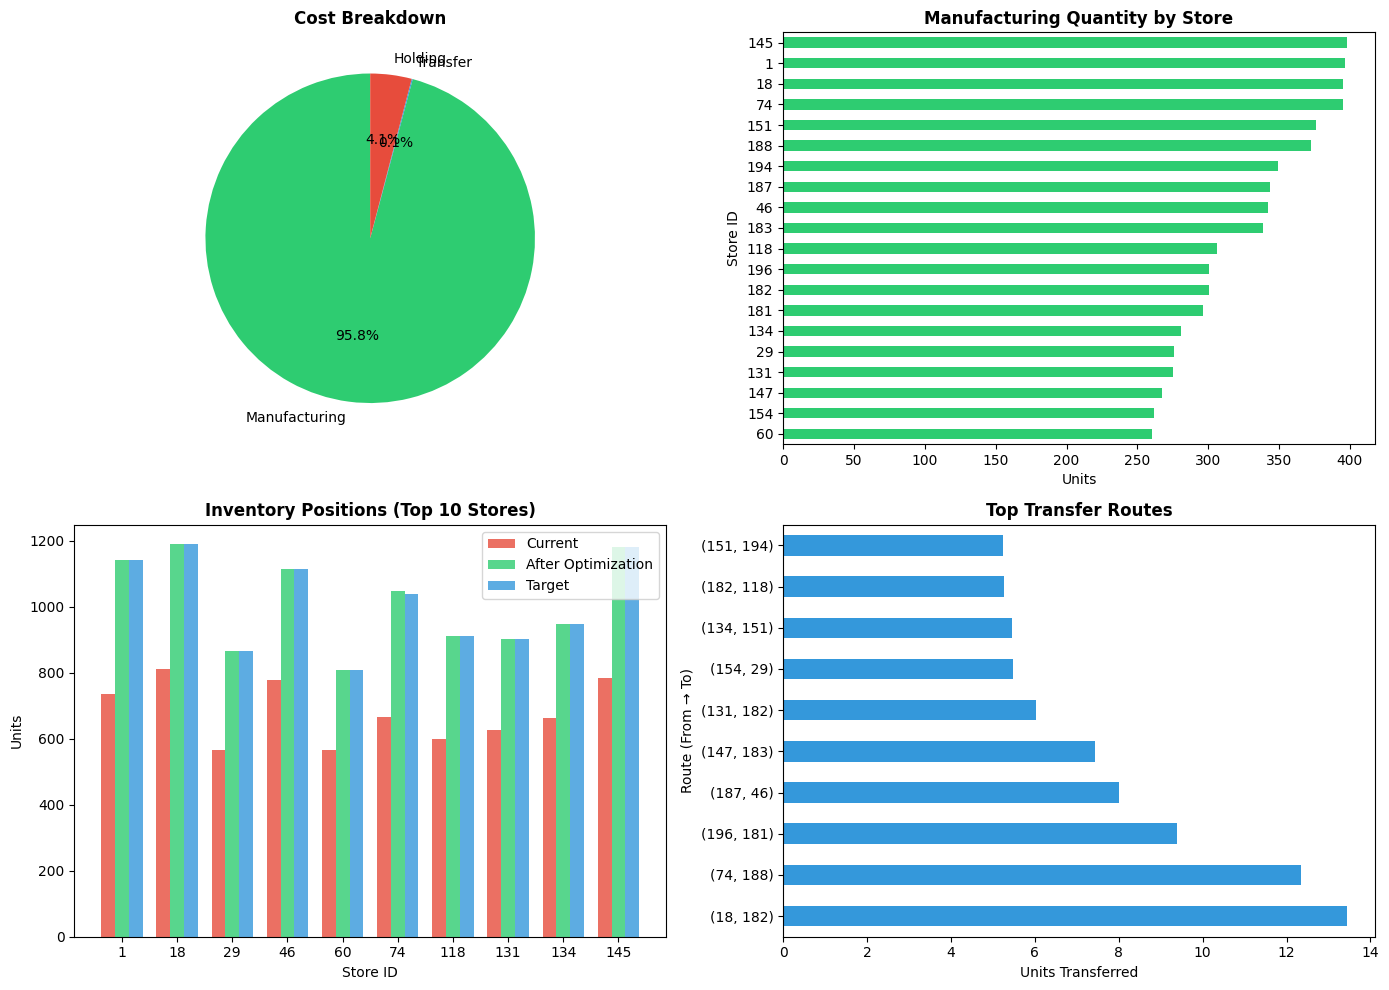


Visualization saved to: ../data/optimization_results_summary.png


In [21]:
# =============================================================================
# Visualizations
# =============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cost breakdown pie chart
ax1 = axes[0, 0]
costs = [total_mfg_cost, total_transfer_cost, total_holding_cost]
labels = ['Manufacturing', 'Transfer', 'Holding']
colors = ['#2ecc71', '#3498db', '#e74c3c']
ax1.pie(costs, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Cost Breakdown', fontsize=12, fontweight='bold')

# 2. Manufacturing by store
ax2 = axes[0, 1]
if len(mfg_df) > 0:
    store_mfg = mfg_df.groupby('store_id')['manufacturing_qty'].sum().sort_values(ascending=True)
    store_mfg.plot(kind='barh', ax=ax2, color='#2ecc71')
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Store ID')
ax2.set_title('Manufacturing Quantity by Store', fontsize=12, fontweight='bold')

# 3. Inventory before vs after optimization
ax3 = axes[1, 0]
store_inv = inventory_df.groupby('store_id').agg({
    'current_inventory': 'sum',
    'final_inventory': 'sum',
    'target_inventory': 'sum'
}).head(10)  # Top 10 stores
x = range(len(store_inv))
width = 0.25
ax3.bar([i - width for i in x], store_inv['current_inventory'], width, label='Current', color='#e74c3c', alpha=0.8)
ax3.bar(x, store_inv['final_inventory'], width, label='After Optimization', color='#2ecc71', alpha=0.8)
ax3.bar([i + width for i in x], store_inv['target_inventory'], width, label='Target', color='#3498db', alpha=0.8)
ax3.set_xticks(x)
ax3.set_xticklabels(store_inv.index)
ax3.set_xlabel('Store ID')
ax3.set_ylabel('Units')
ax3.legend()
ax3.set_title('Inventory Positions (Top 10 Stores)', fontsize=12, fontweight='bold')

# 4. Transfer network summary
ax4 = axes[1, 1]
if len(transfer_df) > 0:
    top_routes = transfer_df.groupby(['from_store', 'to_store'])['transfer_qty'].sum().nlargest(10)
    top_routes.plot(kind='barh', ax=ax4, color='#3498db')
    ax4.set_xlabel('Units Transferred')
    ax4.set_ylabel('Route (From → To)')
ax4.set_title('Top Transfer Routes', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/optimization_results_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nVisualization saved to: ../data/optimization_results_summary.png")


## 9. Save Results


In [22]:
# =============================================================================
# Save Results to Files
# =============================================================================

# Save detailed results to CSV
mfg_df.to_csv('../data/optimization_manufacturing.csv', index=False)
transfer_df.to_csv('../data/optimization_transfers.csv', index=False)
inventory_df.to_csv('../data/optimization_inventory.csv', index=False)

# Create JSON summary for API/integration
optimization_summary = {
    'status': LpStatus[status],
    'total_cost': round(total_cost, 2),
    'cost_breakdown': {
        'manufacturing': round(total_mfg_cost, 2),
        'transfer': round(total_transfer_cost, 2),
        'holding': round(total_holding_cost, 2)
    },
    'metrics': {
        'total_manufacturing_units': round(mfg_df['manufacturing_qty'].sum() if len(mfg_df) > 0 else 0, 1),
        'total_transfer_units': round(transfer_df['transfer_qty'].sum() if len(transfer_df) > 0 else 0, 1),
        'stores_optimized': n_stores,
        'products_optimized': n_products,
        'manufacturing_decisions': len(mfg_df),
        'transfer_decisions': len(transfer_df)
    },
    'planning_horizon_days': 7
}

with open('../data/optimization_summary.json', 'w') as f:
    json.dump(optimization_summary, f, indent=2)

print("Results saved:")
print("  - optimization_manufacturing.csv")
print("  - optimization_transfers.csv") 
print("  - optimization_inventory.csv")
print("  - optimization_summary.json")

print("\n" + "=" * 60)
print("JSON Summary:")
print("=" * 60)
print(json.dumps(optimization_summary, indent=2))


Results saved:
  - optimization_manufacturing.csv
  - optimization_transfers.csv
  - optimization_inventory.csv
  - optimization_summary.json

JSON Summary:
{
  "status": "Optimal",
  "total_cost": 497847.62,
  "cost_breakdown": {
    "manufacturing": 477151.17,
    "transfer": 507.1,
    "holding": 20189.35
  },
  "metrics": {
    "total_manufacturing_units": 6531.6,
    "total_transfer_units": 253.6,
    "stores_optimized": 20,
    "products_optimized": 139,
    "manufacturing_decisions": 842,
    "transfer_decisions": 145
  },
  "planning_horizon_days": 7
}


## 10. Store-Level Recommendations

Actionable recommendations for each store based on optimization results.


In [23]:
# =============================================================================
# Generate Store-Level Recommendations
# =============================================================================

store_recommendations = []

for store_id in stores:
    # Manufacturing for this store
    store_mfg = mfg_df[mfg_df['store_id'] == store_id] if len(mfg_df) > 0 else pd.DataFrame()
    total_mfg = store_mfg['manufacturing_qty'].sum() if len(store_mfg) > 0 else 0
    
    # Incoming transfers
    incoming = transfer_df[transfer_df['to_store'] == store_id] if len(transfer_df) > 0 else pd.DataFrame()
    total_incoming = incoming['transfer_qty'].sum() if len(incoming) > 0 else 0
    
    # Outgoing transfers
    outgoing = transfer_df[transfer_df['from_store'] == store_id] if len(transfer_df) > 0 else pd.DataFrame()
    total_outgoing = outgoing['transfer_qty'].sum() if len(outgoing) > 0 else 0
    
    # Inventory status
    store_inv = inventory_df[inventory_df['store_id'] == store_id]
    current_total = store_inv['current_inventory'].sum()
    final_total = store_inv['final_inventory'].sum()
    target_total = store_inv['target_inventory'].sum()
    
    store_recommendations.append({
        'store_id': store_id,
        'action_manufacture': round(total_mfg, 1),
        'action_receive_from': len(incoming),
        'action_receive_qty': round(total_incoming, 1),
        'action_send_to': len(outgoing),
        'action_send_qty': round(total_outgoing, 1),
        'current_inventory': round(current_total, 1),
        'final_inventory': round(final_total, 1),
        'target_inventory': round(target_total, 1),
        'gap_covered': round(final_total - current_total, 1)
    })

recommendations_df = pd.DataFrame(store_recommendations)
recommendations_df.to_csv('../data/optimization_store_recommendations.csv', index=False)

print("Store-Level Recommendations:")
print("=" * 80)
display(recommendations_df)


Store-Level Recommendations:


,store_id,action_manufacture,action_receive_from,action_receive_qty,action_send_to,action_send_qty,current_inventory,final_inventory,target_inventory,gap_covered
0,1,396.3,7,11.1,1,1.3,737.4,1143.5,1143.5,406.1
1,18,395.2,4,4.4,9,21.6,811.4,1189.4,1189.4,378.0
2,29,276.1,14,24.3,3,2.8,567.4,864.9,864.9,297.6
3,46,341.9,9,16.4,13,21.9,779.8,1116.2,1116.2,336.4
4,60,260.4,5,4.2,16,22.1,565.4,807.9,807.9,242.5
5,74,395.0,4,6.1,6,19.8,665.9,1047.2,1038.1,381.3
6,118,306.1,8,14.4,7,6.6,599.0,912.7,912.6,313.8
7,131,275.4,14,16.5,6,16.0,626.8,902.7,901.8,275.9
8,134,280.6,9,12.4,6,9.4,663.7,947.3,947.3,283.6
9,145,397.6,12,13.0,7,12.2,783.1,1181.5,1181.5,398.4


---

## Summary

This optimization model successfully:
1. **Integrated demand forecasts** from the LightGBM model (7-day horizon, 20 stores × 50 products)
2. **Calculated safety stock** using risk-adjusted formulas based on supply chain parameters
3. **Optimized inventory allocation** through manufacturing and inter-store transfers
4. **Minimized total cost** including manufacturing, transport, and holding costs

### Output Files
- `optimization_manufacturing.csv` - Manufacturing decisions per store-product
- `optimization_transfers.csv` - Inter-store transfer recommendations  
- `optimization_inventory.csv` - Final inventory positions
- `optimization_store_recommendations.csv` - Actionable store-level summary
- `optimization_summary.json` - JSON summary for API integration
